In [1]:
%matplotlib inline
import sys
sys.path.append('/home/ubuntu/tools/python-genomics')
import Scanpyplus
import scanpy as sc
import anndata
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
plt.show()
matplotlib.rcParams.update({'figure.figsize': (8,8)})

# This notebook shows how to integrate datasets with weak batch effect without doing correction

##### Run default processing (required to generate embedding and colors)

In [2]:
adata=sc.read('Xi2021.h5ad',backup_url='https://www.dropbox.com/s/nr8j62anzgbb25q/Xi2021.h5ad?dl=1') #Data from Xi et al. 2020 on Cell Stem Cell

Xi2021.h5ad: 0.00B [00:00, ?B/s]

/home/ubuntu/miniconda3/envs/flng/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


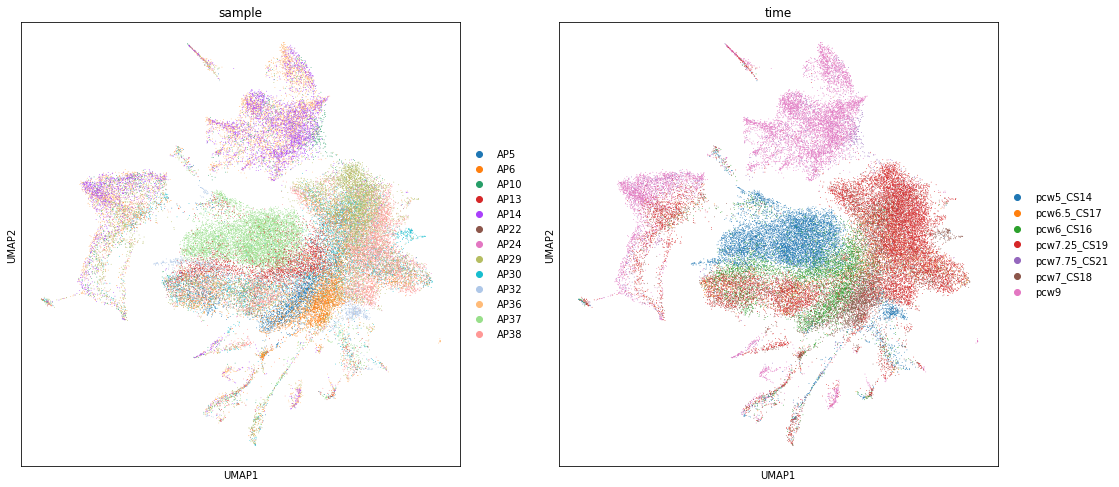

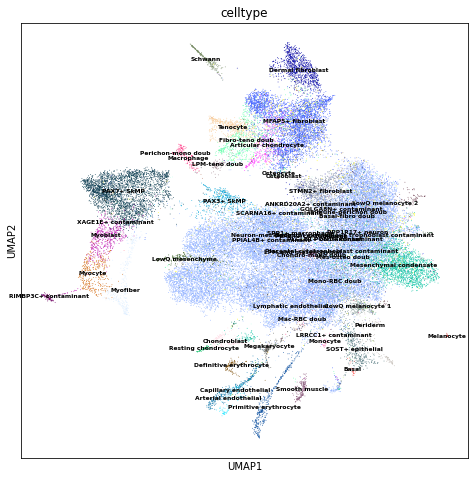

In [3]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw=adata
adata=adata[:,adata.var['highly_variable']]
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=['sample','time'])
sc.pl.umap(adata,color='celltype',legend_loc='on data',legend_fontsize=6)

The default setting is already good because this dataset has very small batch effect. Below you can find how to do soft integration

## Extract Deep genes per batch

##### Go back to un-scaled data.

Because you scaled it in the Step 0.

In [4]:
adata=Scanpyplus.GetRaw(adata)

##### Calculate highly variable genes per batch

In [5]:
adata=Scanpyplus.HVGbyBatch(adata,'sample')

AP29


Trying to set attribute `.var` of view, copying.


AP37


Trying to set attribute `.var` of view, copying.


AP36


Trying to set attribute `.var` of view, copying.


AP38


Trying to set attribute `.var` of view, copying.


AP30


Trying to set attribute `.var` of view, copying.


AP14


Trying to set attribute `.var` of view, copying.


AP6


Trying to set attribute `.var` of view, copying.


AP13


Trying to set attribute `.var` of view, copying.


AP5


Trying to set attribute `.var` of view, copying.


AP22


Trying to set attribute `.var` of view, copying.


AP10


Trying to set attribute `.var` of view, copying.


AP24


Trying to set attribute `.var` of view, copying.


AP32


Trying to set attribute `.var` of view, copying.


##### Inspect deep genes per batch (this takes long due to hierarchical clustering)

Deep genes are defined as highly-correlated genes among a list of genes. They are usually not technical genes within one batch.
More details can be found in the DeepTree algorithm notebook

Trying to set attribute `.var` of view, copying.


AP29


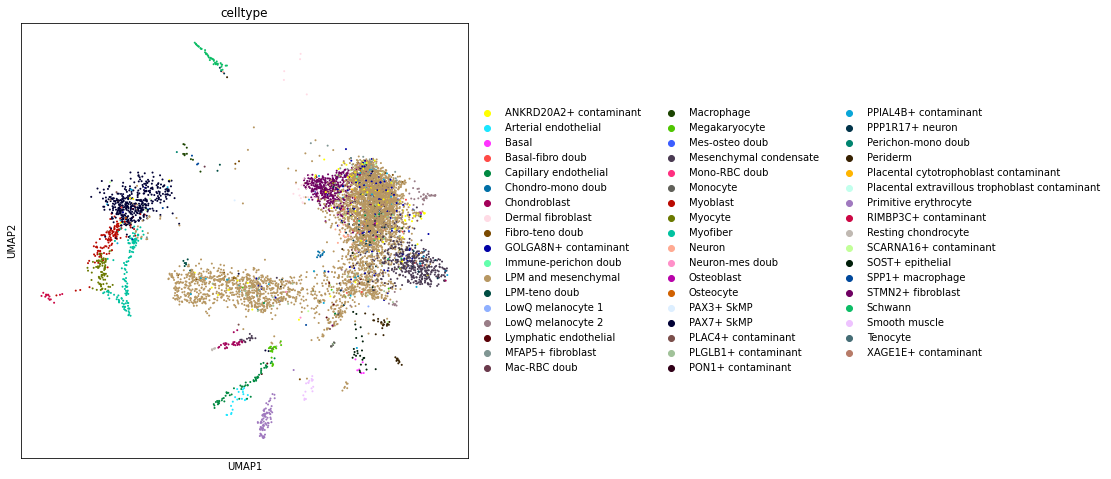

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


AP37


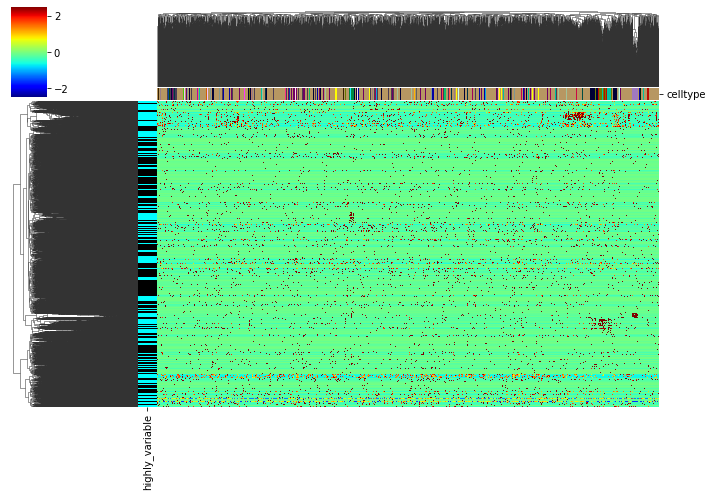

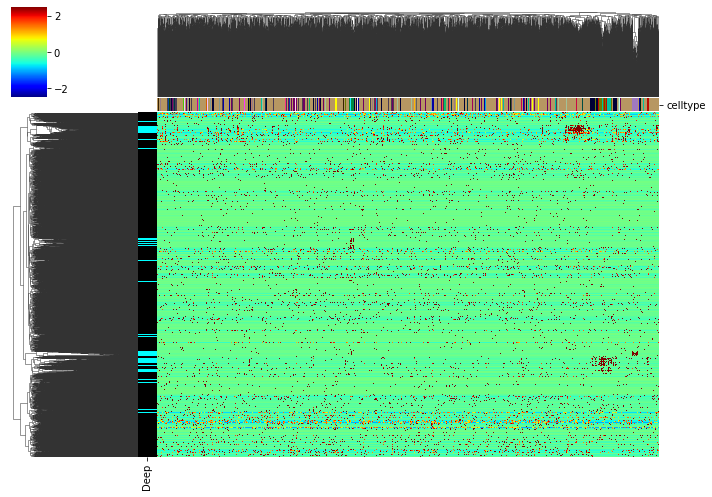

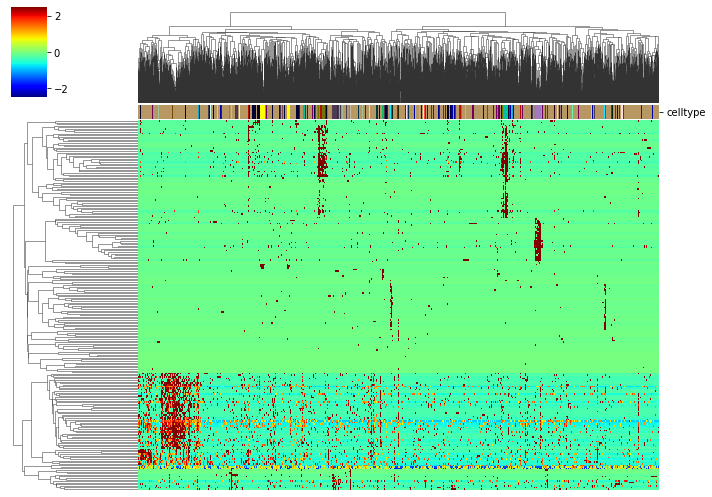

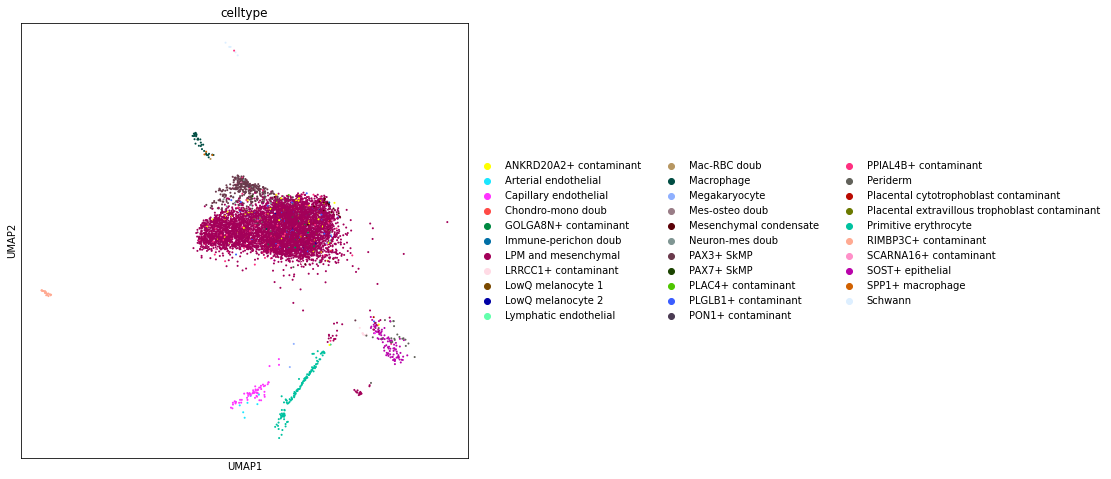

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


AP36


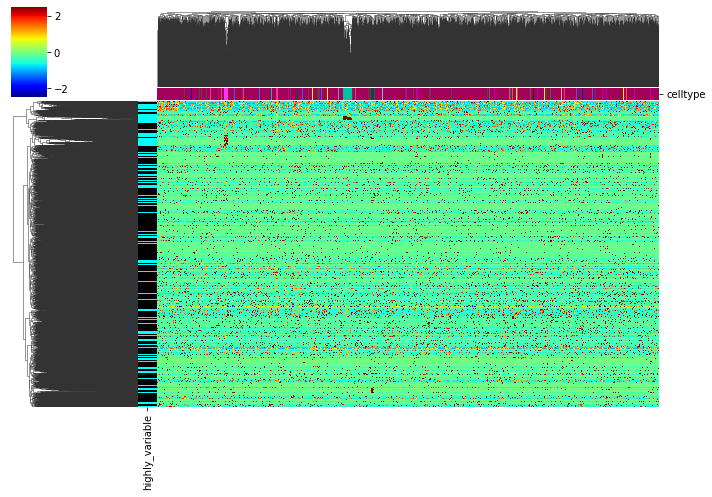

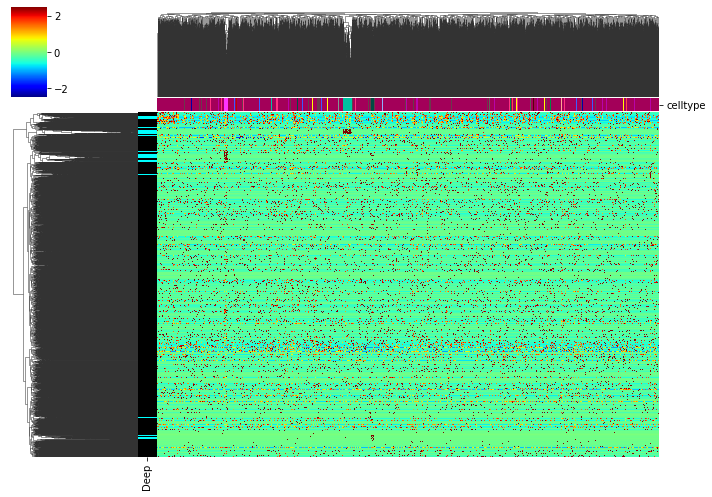

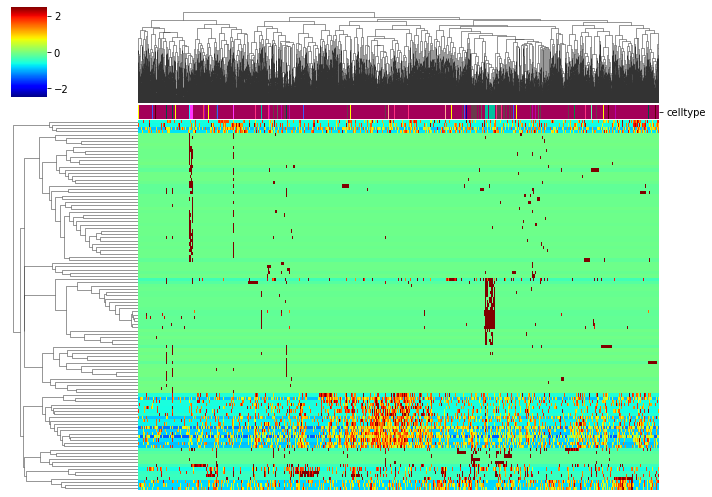

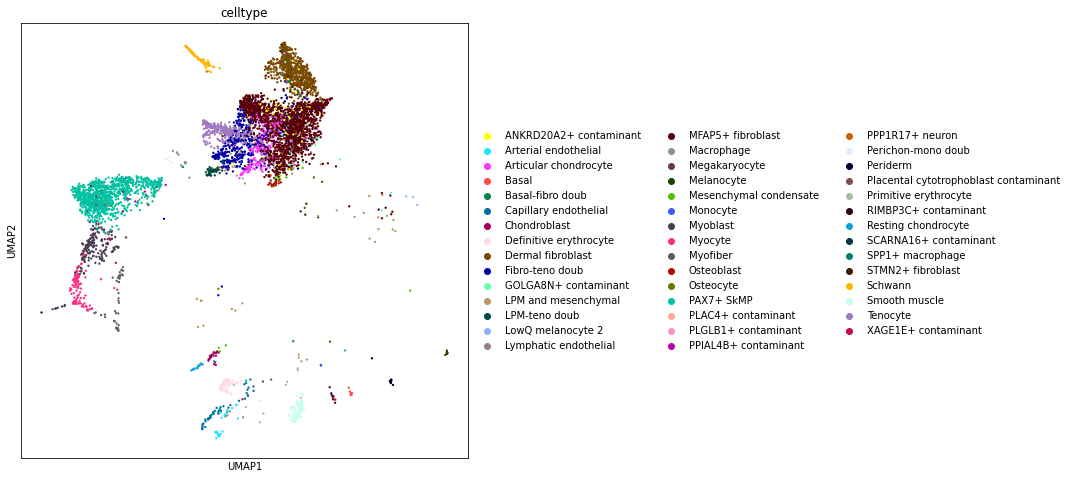

Trying to set attribute `.var` of view, copying.


AP38
filtered out 1 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


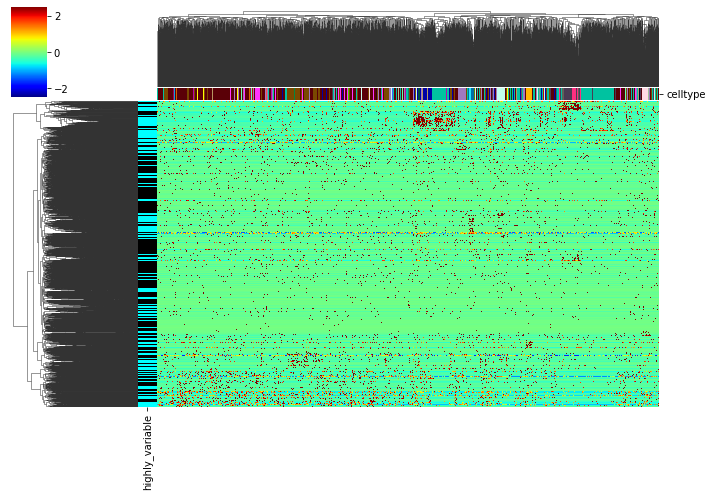

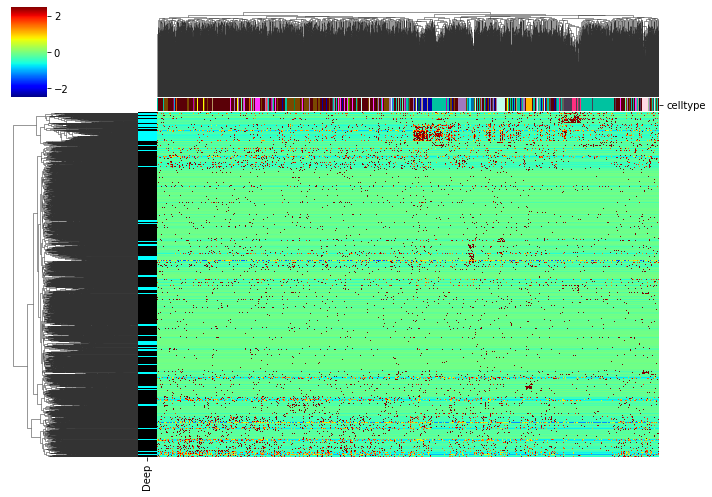

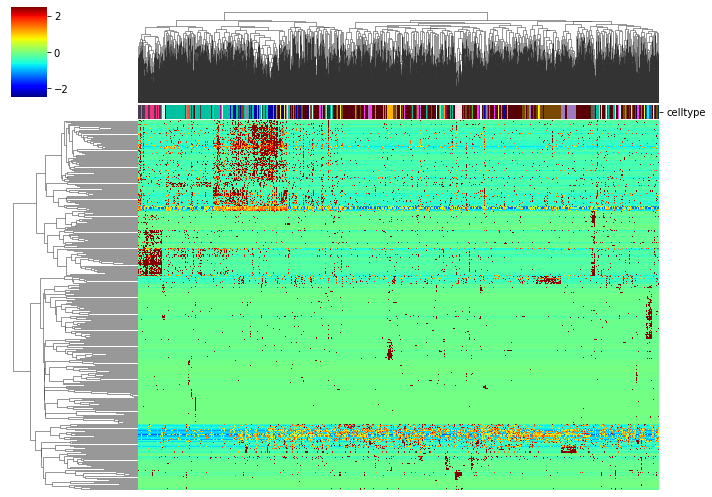

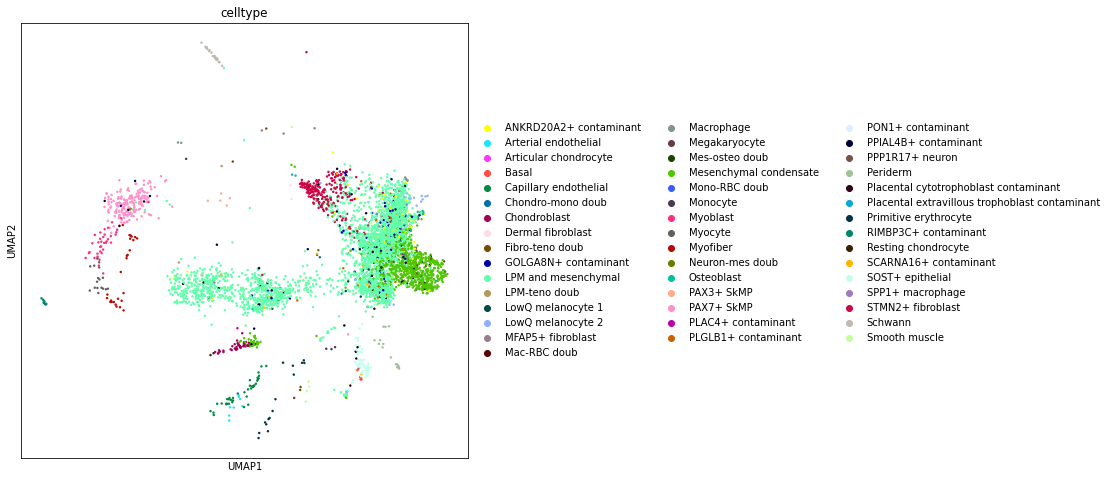

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


AP30


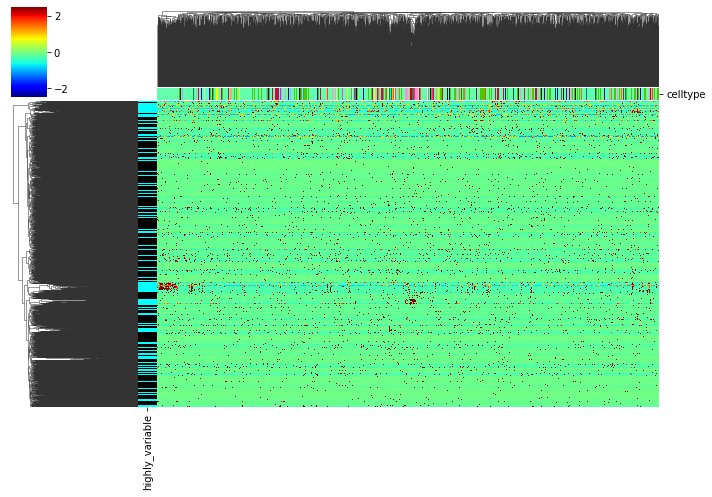

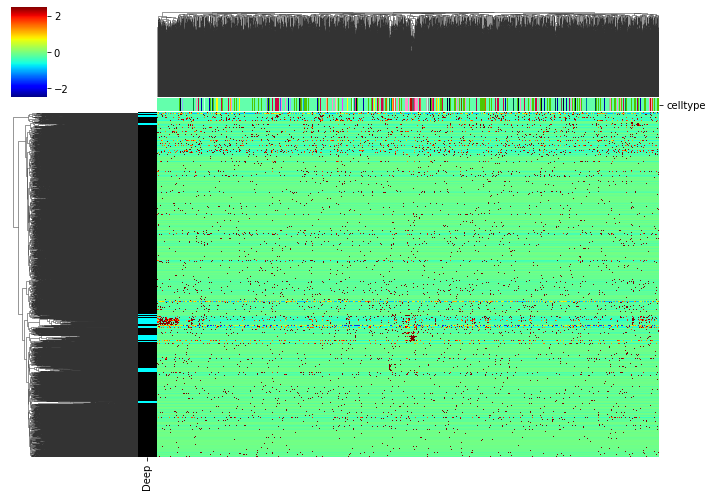

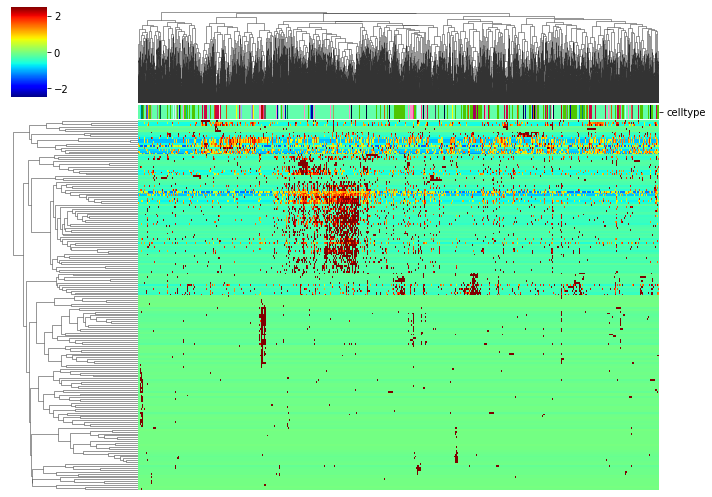

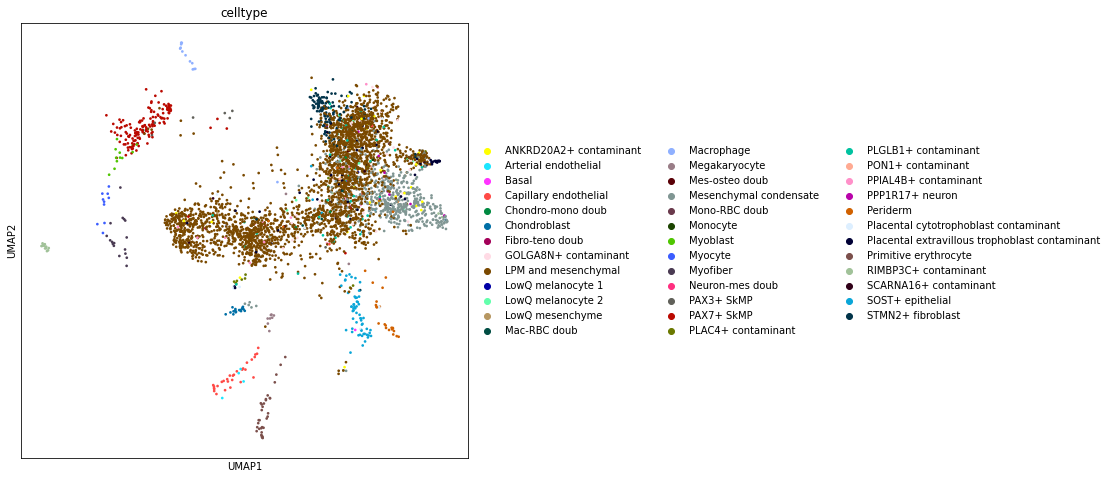

Trying to set attribute `.var` of view, copying.


AP14
filtered out 1 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


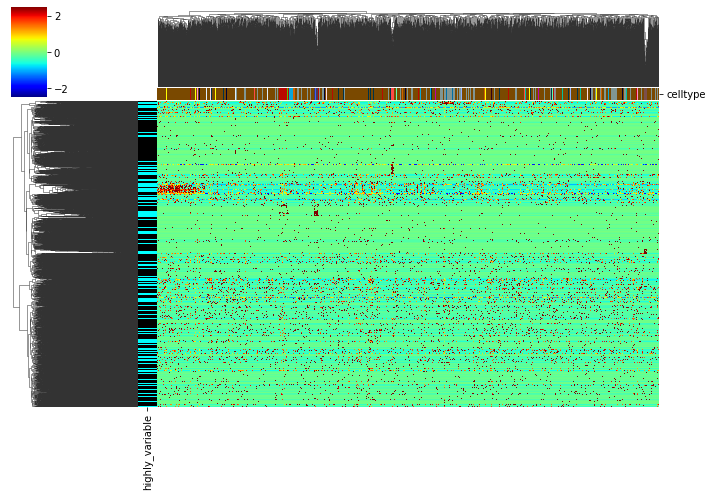

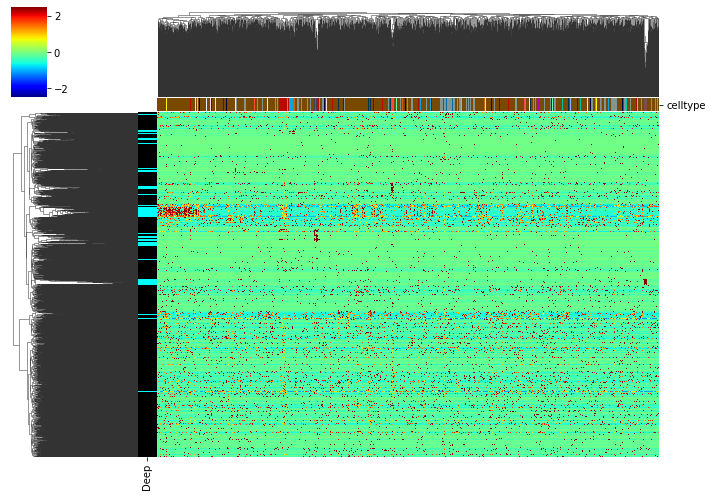

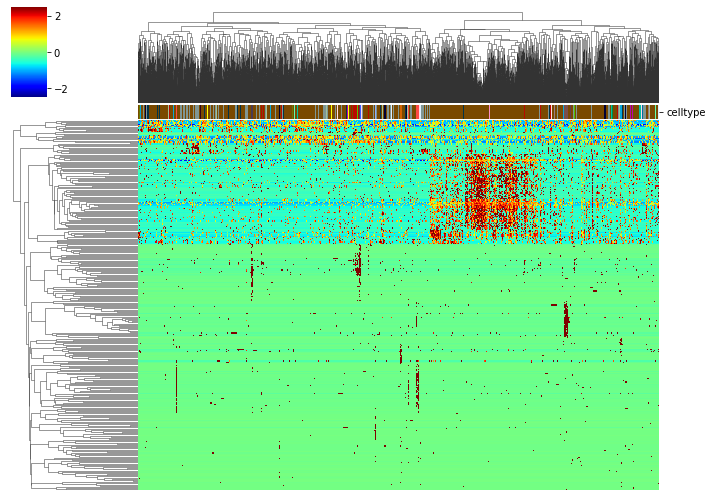

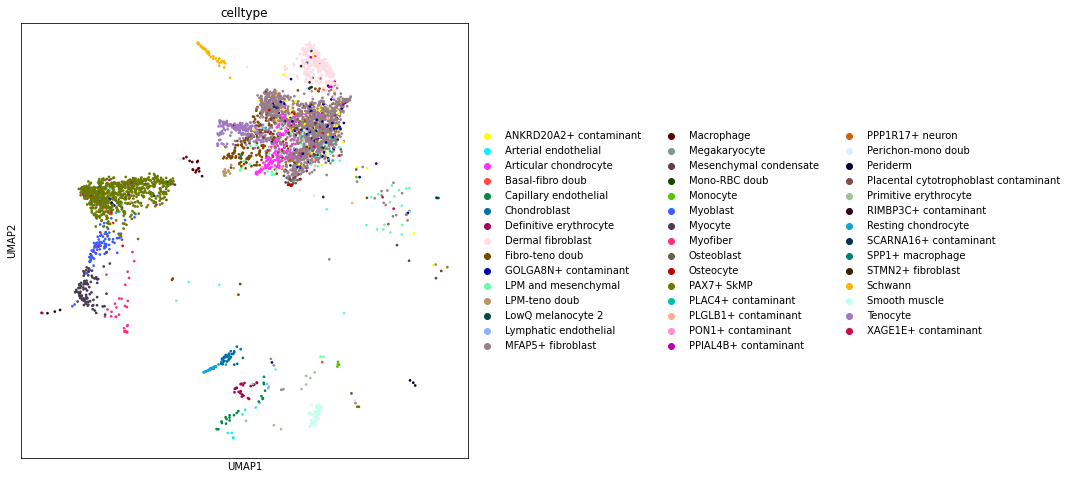

Trying to set attribute `.var` of view, copying.


AP6
filtered out 2 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


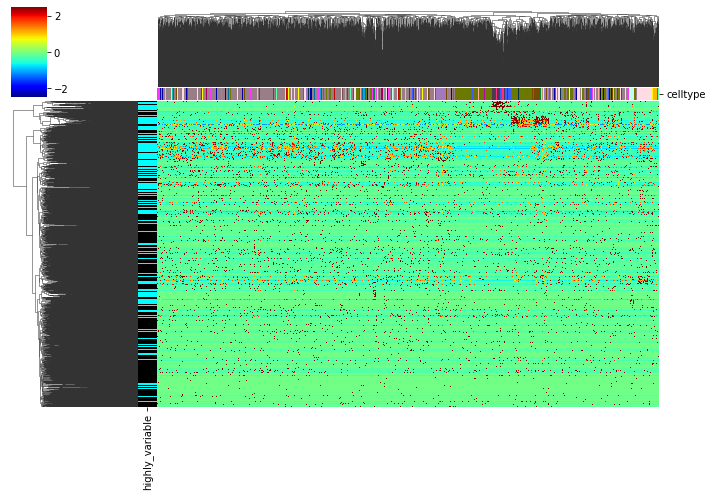

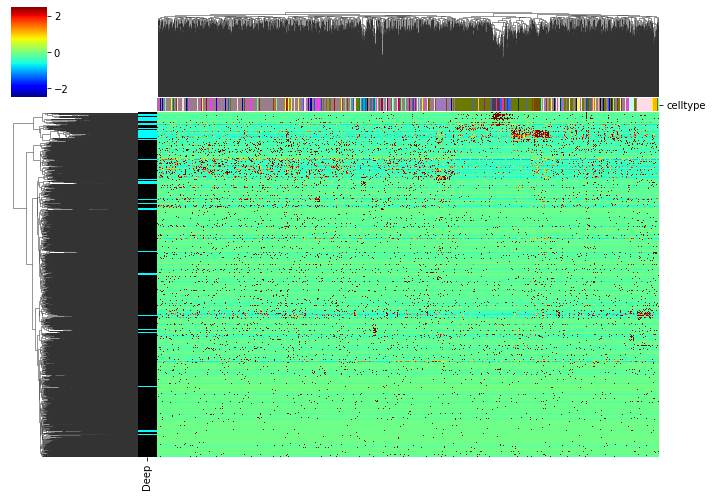

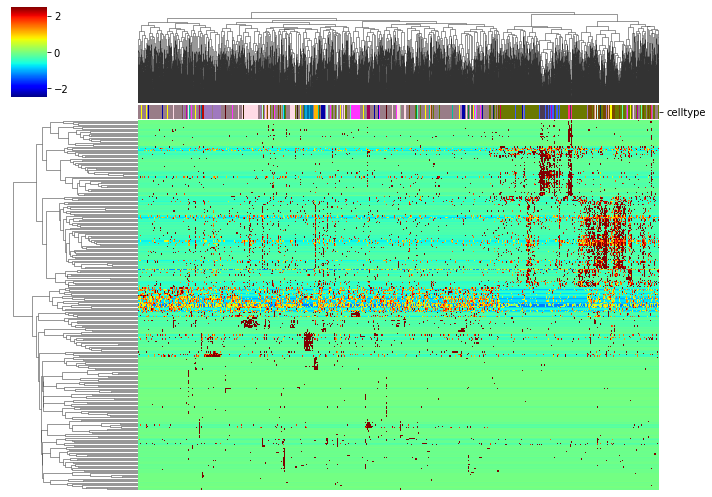

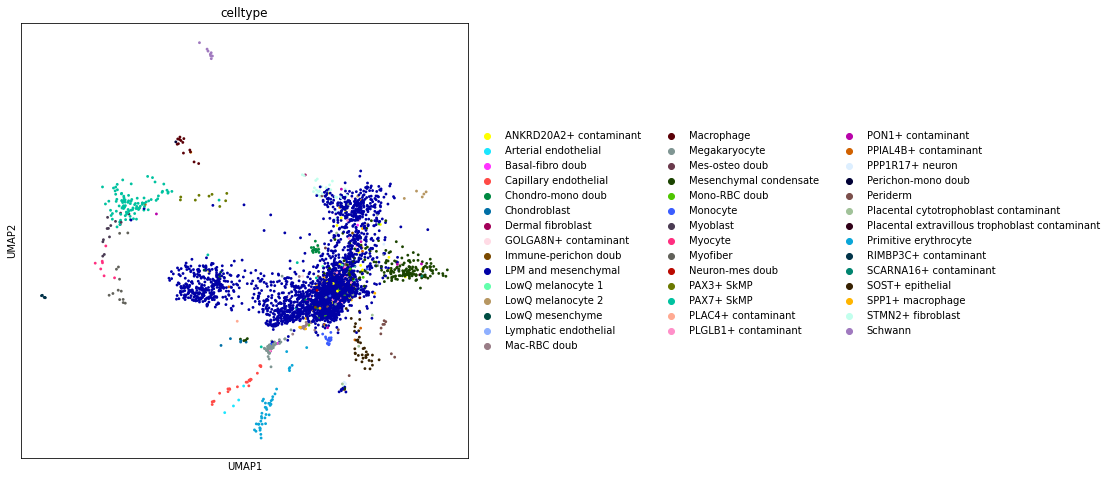

Trying to set attribute `.var` of view, copying.


AP13
filtered out 2 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


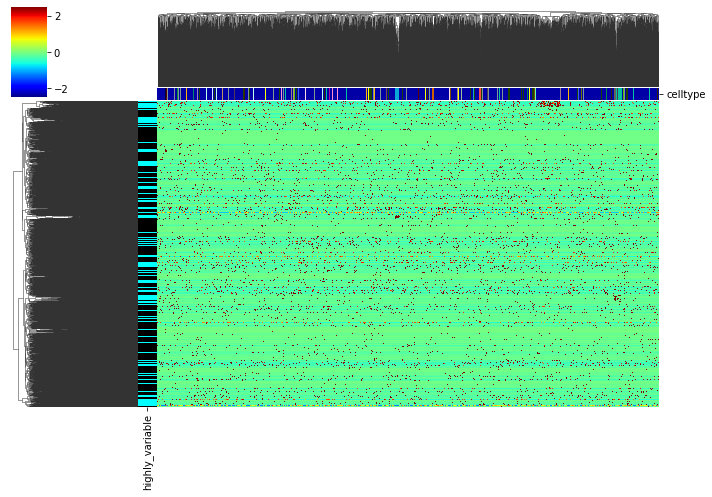

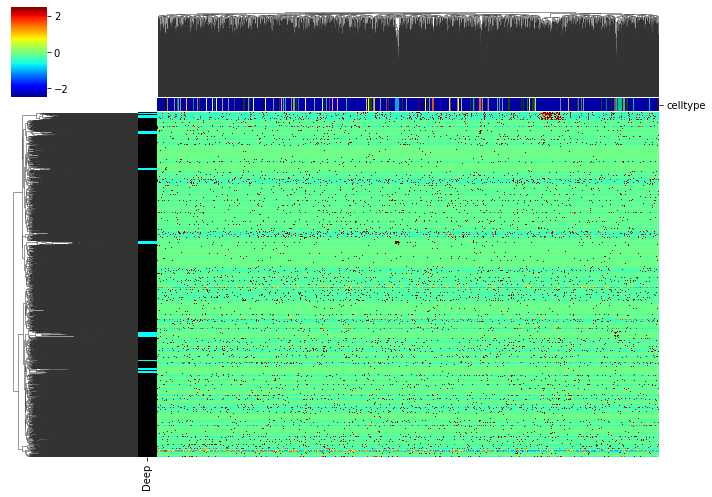

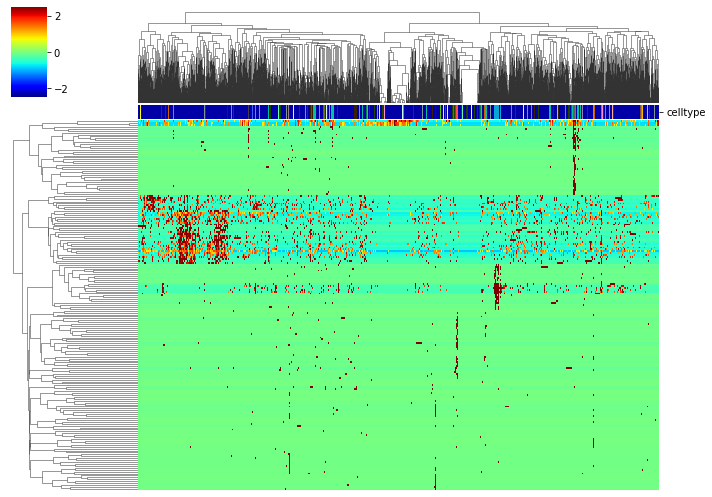

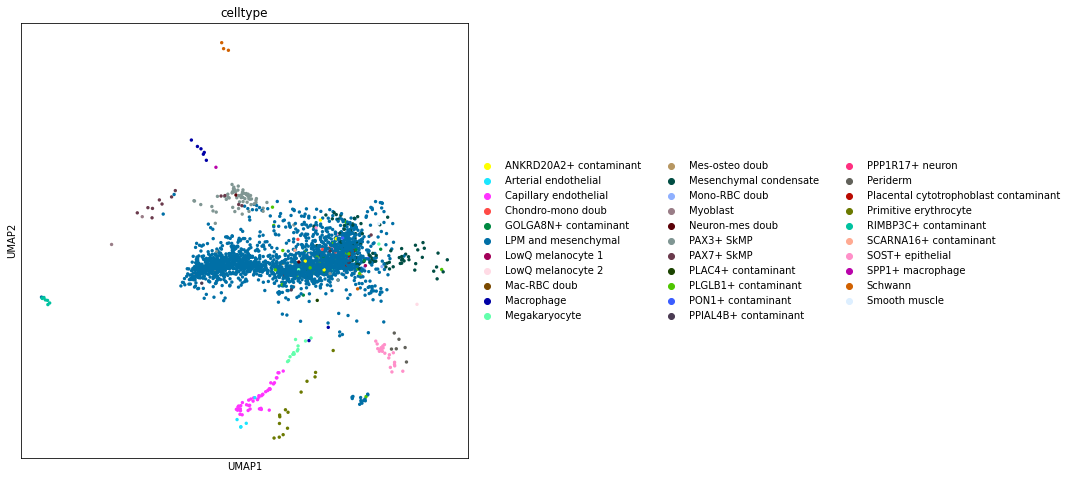

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


AP5


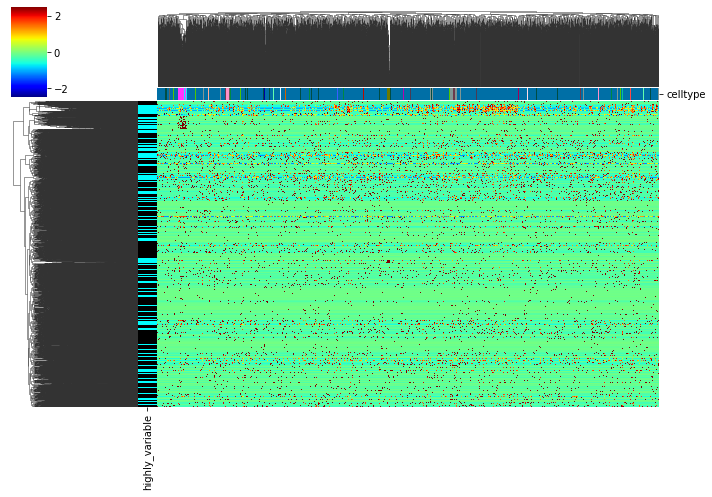

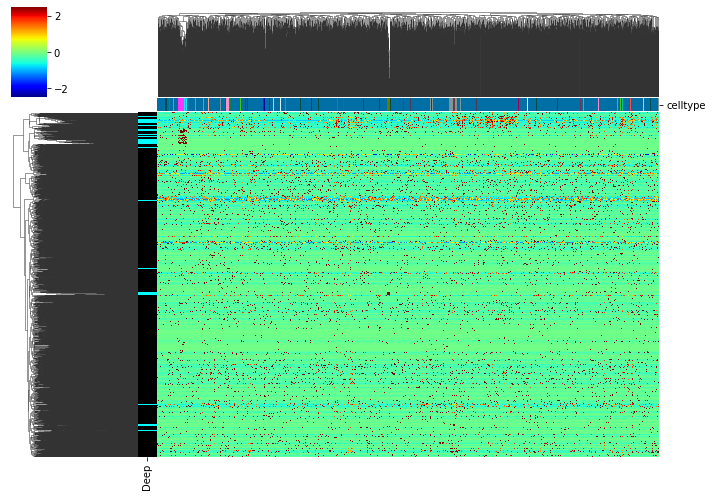

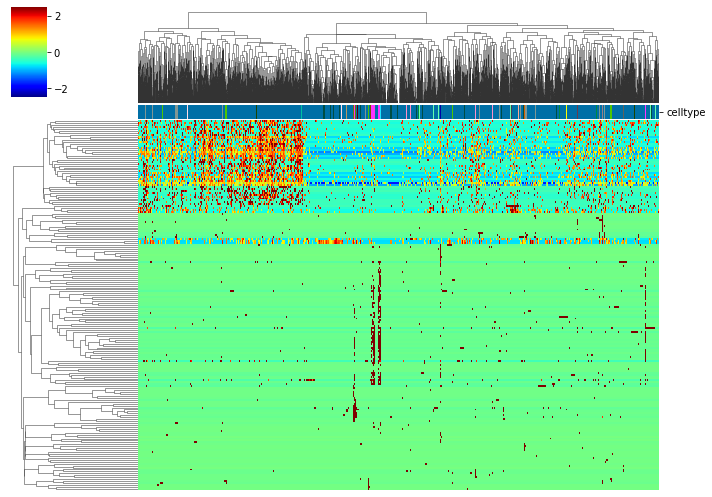

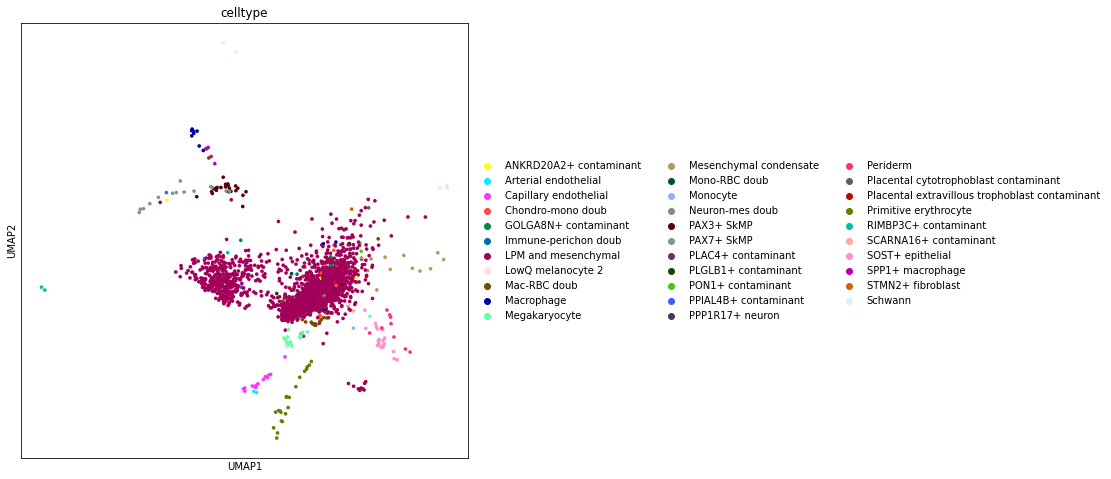

Trying to set attribute `.var` of view, copying.


AP22
filtered out 3 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


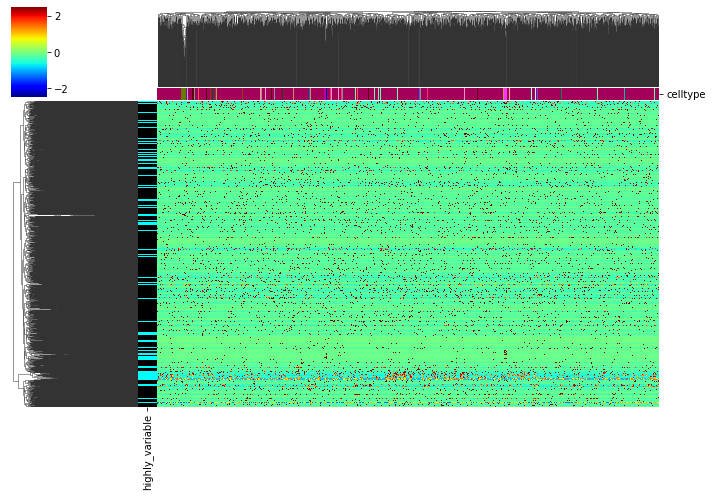

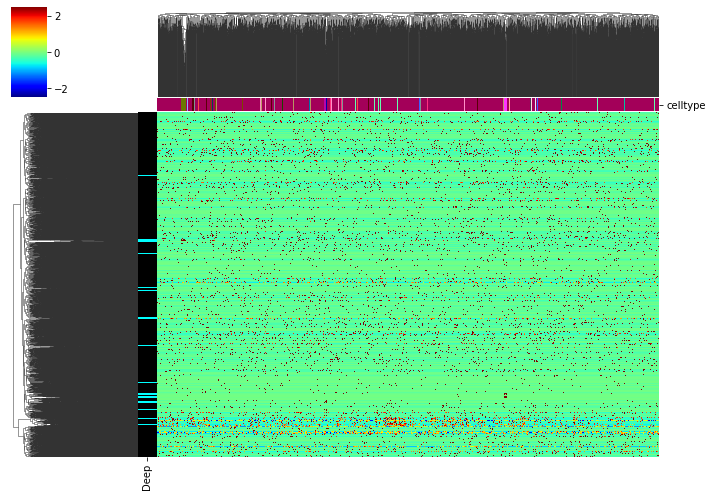

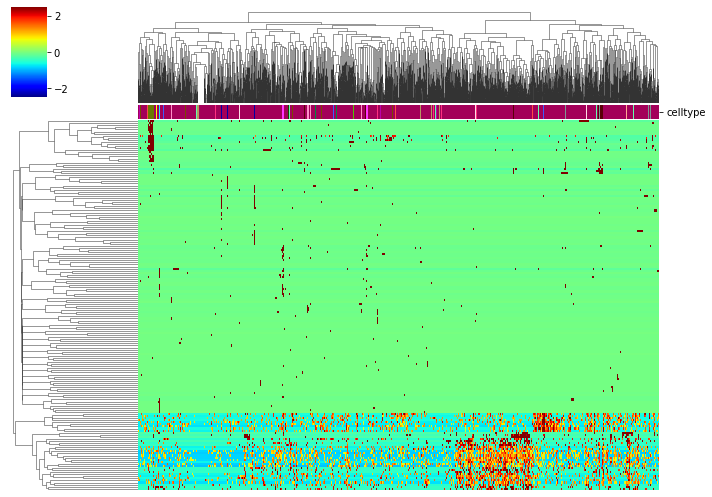

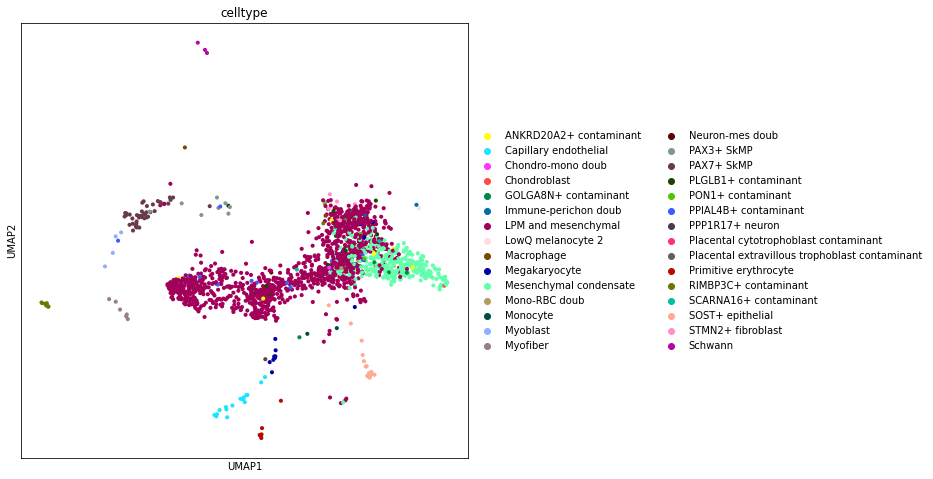

Trying to set attribute `.var` of view, copying.


AP10
filtered out 22 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


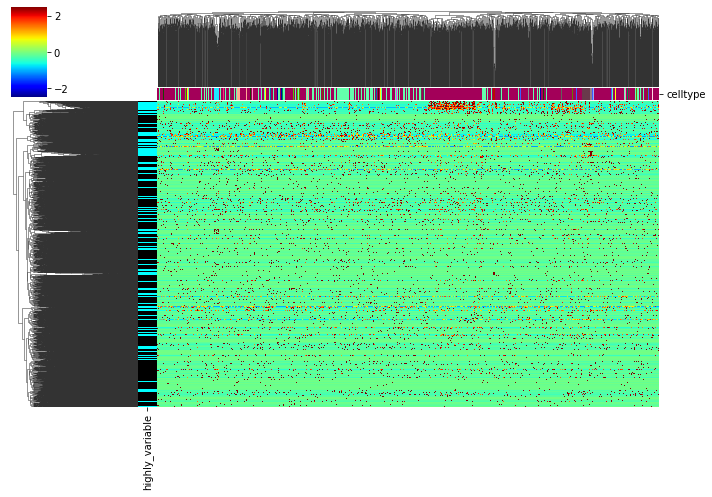

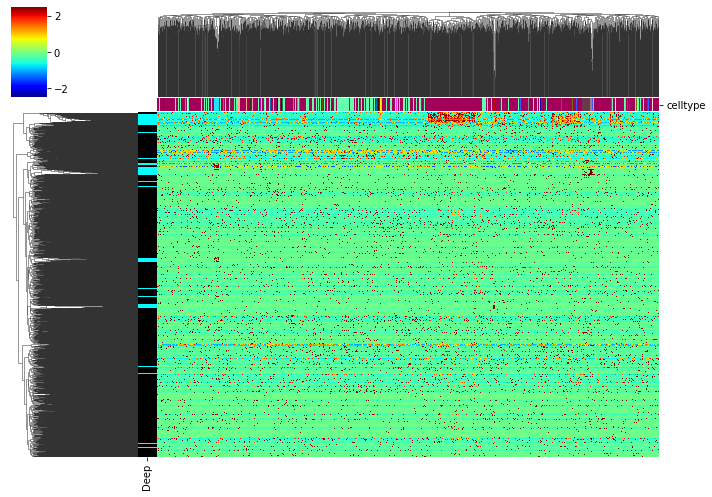

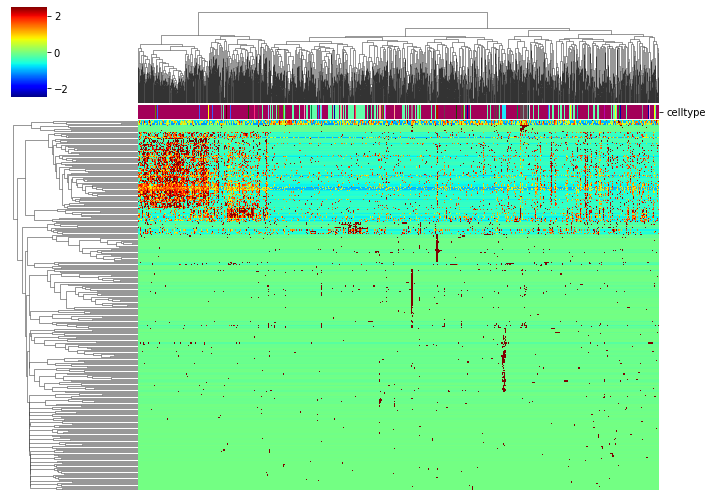

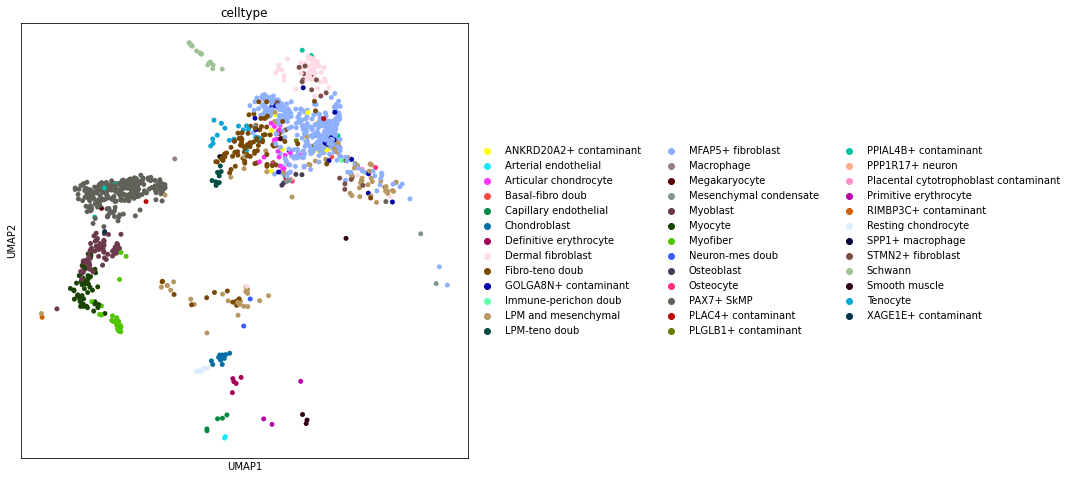

Trying to set attribute `.var` of view, copying.


AP24
filtered out 234 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


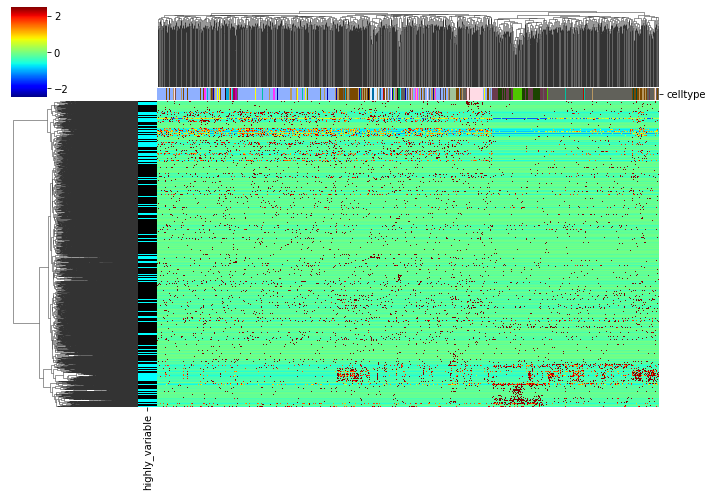

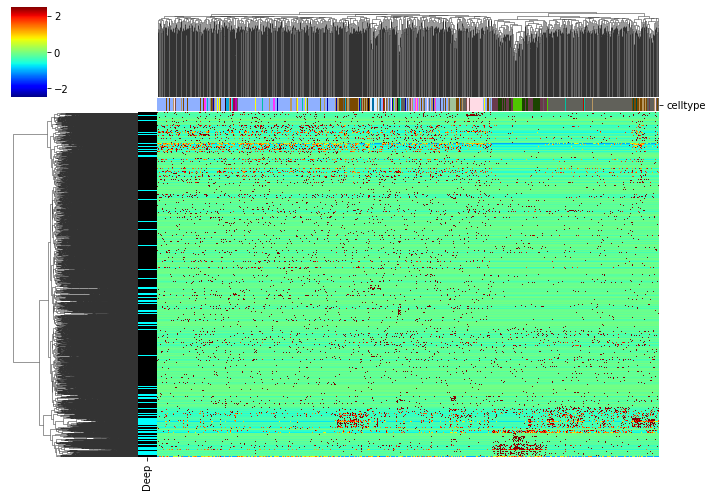

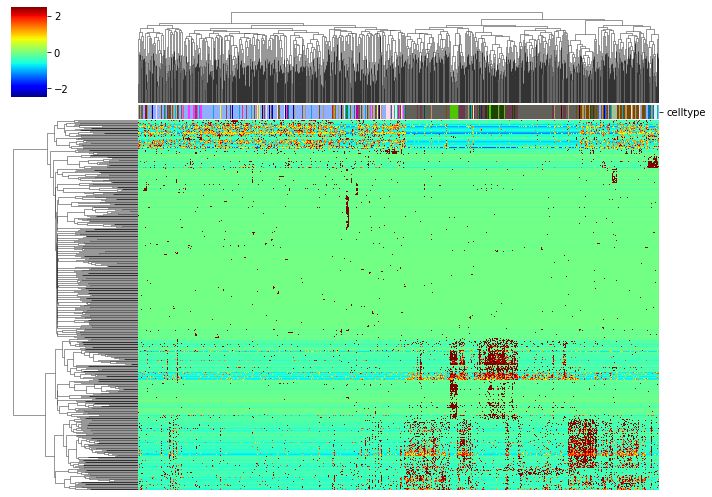

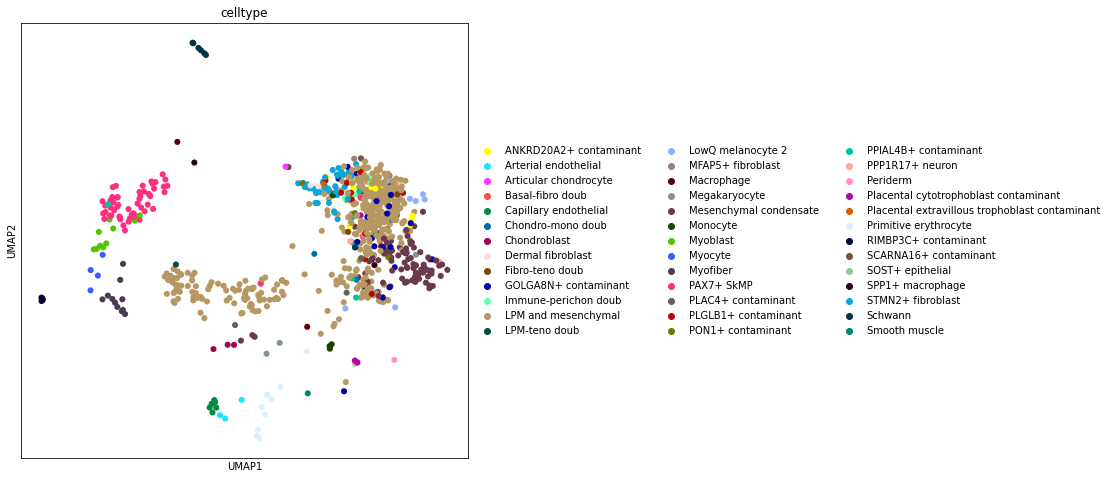

Trying to set attribute `.var` of view, copying.


AP32
filtered out 755 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


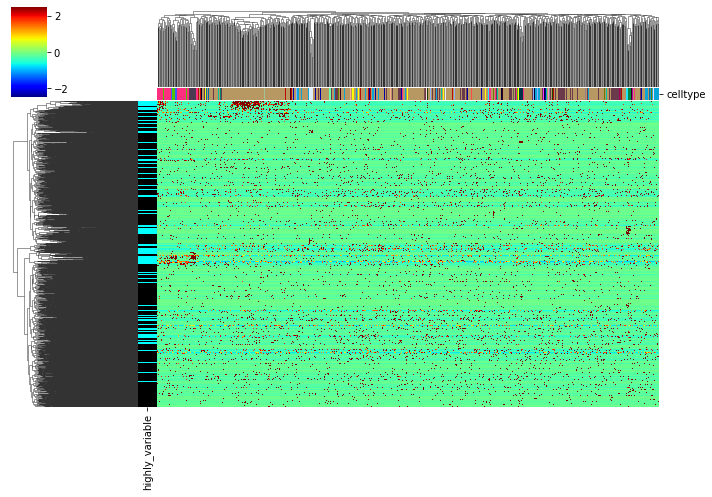

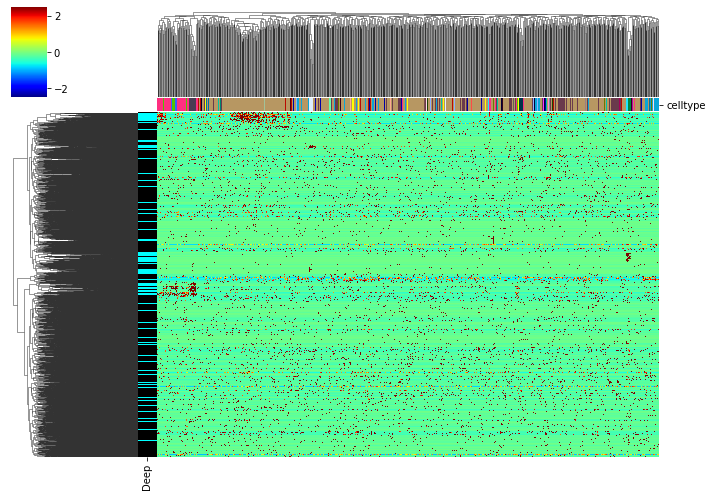

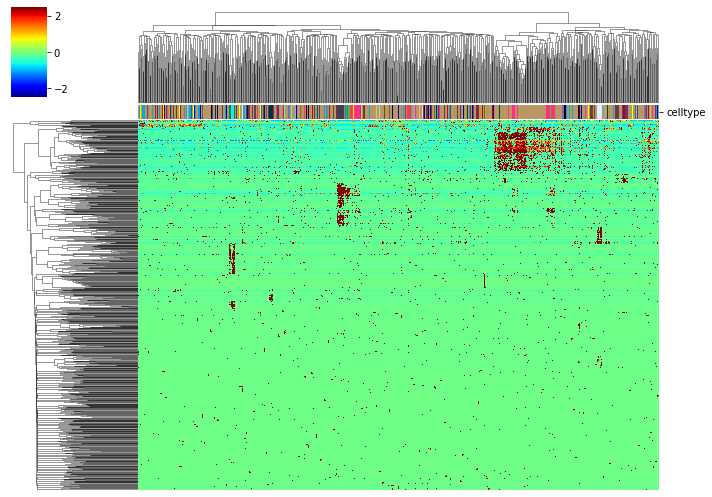

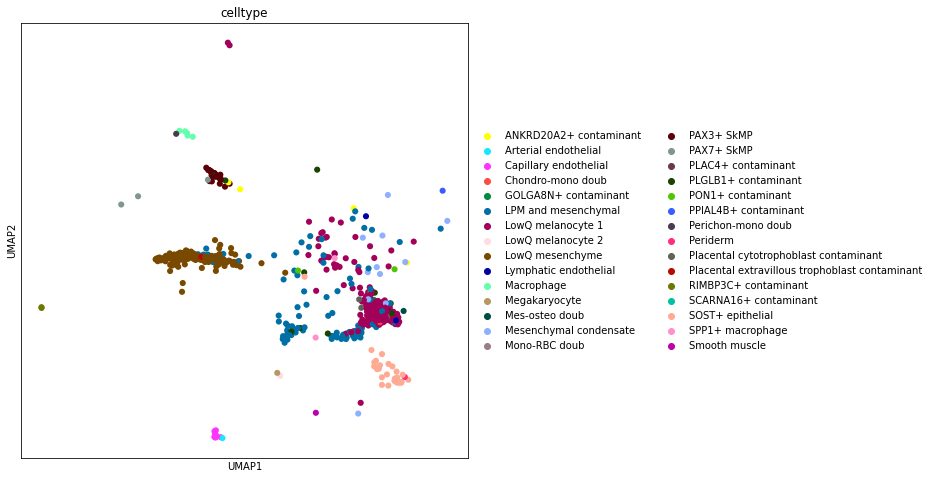

Trying to set attribute `.var` of view, copying.


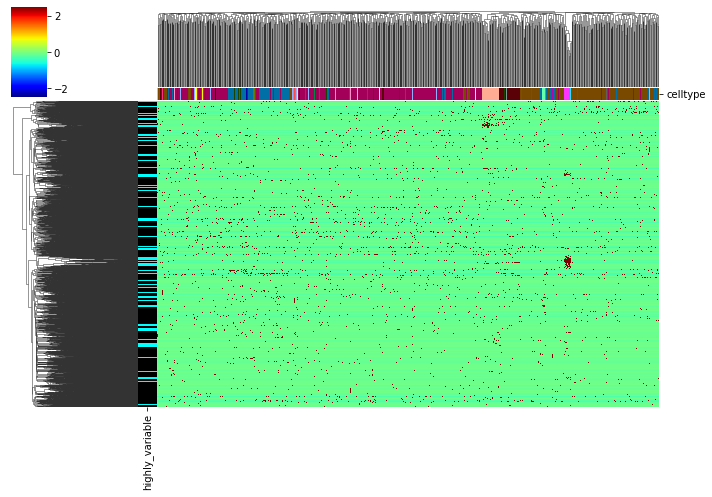

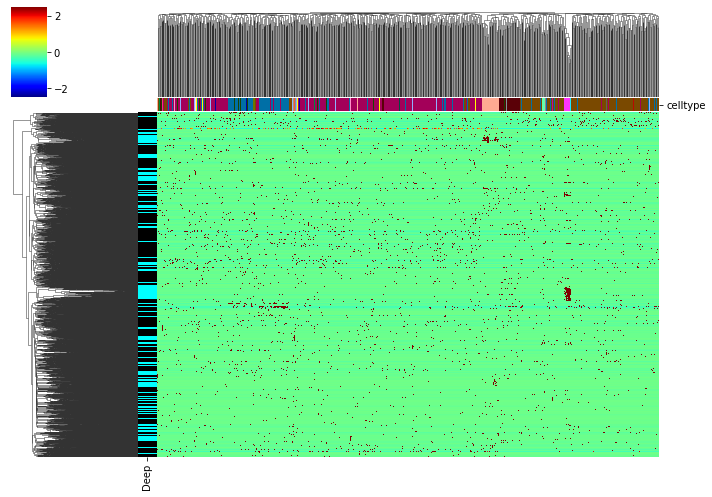

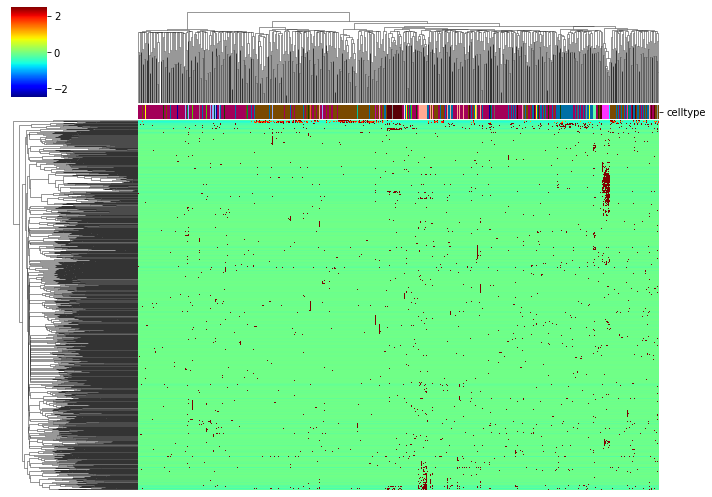

In [6]:
adata=Scanpyplus.DeepTree_per_batch(adata,batch_key='sample',obslist=['celltype'])

The function above isolates cells from each batch and calculate the most correlated highly variable genes in each batch. 

Three heatmaps were shown for the cells in each batch:
1. Batch HVG with global HVG marked in cyan
2. Batch HVG with batch DeepGene marked in cyan
3. Batch DeepGene (highly correlated batch HVG)

These are helpful for you to inspect each sample's quality as well

#### Check how many deep genes are shared across how many batches 

In [7]:
adata.var['Deep_n'].value_counts()

0     18175
1      1659
2       230
3        88
5        54
4        45
6        37
9        36
8        30
7        26
12       24
10       23
11       16
13       12
Name: Deep_n, dtype: int64

From the stats, 1659 genes are deep genes unique to one single sample; 230 deep genes shared by exactly two samples... Considering that the union set has a reasonable number of genes for downstream analysis, we proceed with that.

##### Use the union set (at least in one batch) as feature genes

Trying to set attribute `.var` of view, copying.


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:25)


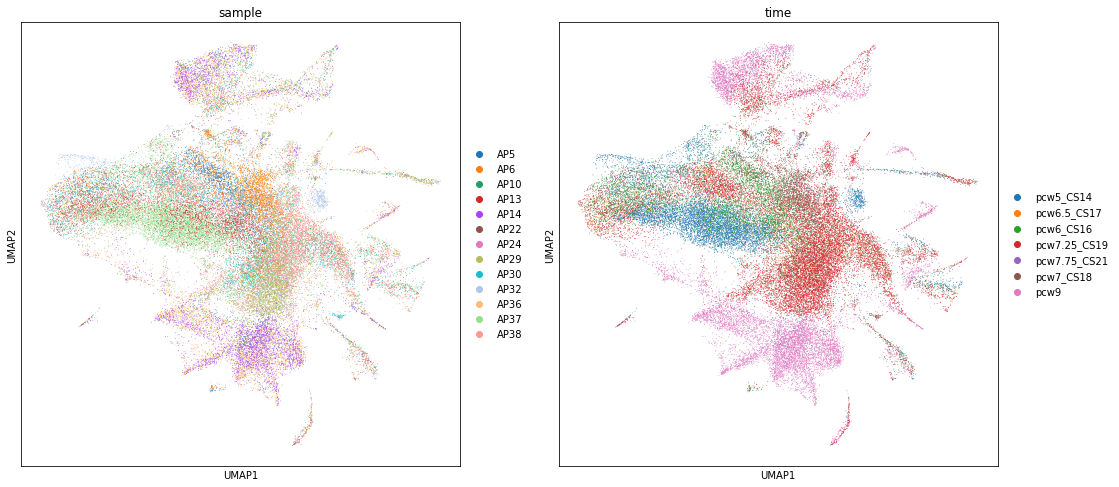

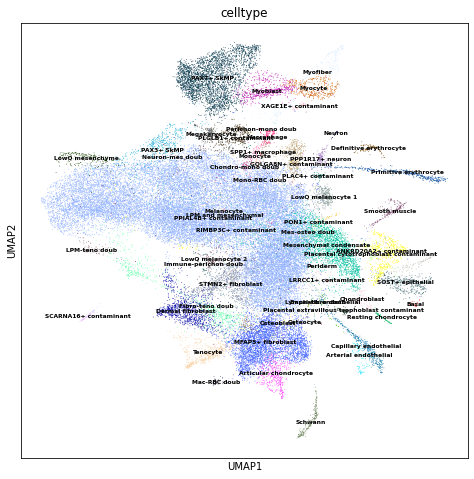

In [8]:
adata.raw=adata
adata=adata[:,adata.var['Deep_n']>0] #You can choose ['Deep_n']>1 or 2
                                    #for smaller gene set
                                    #which may tighten integration
adata.var['highly_variable']=True
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=['sample','time'])
sc.pl.umap(adata,color='celltype',legend_loc='on data',legend_fontsize=6)

To be honest, there is minimal gain by doing this compared to the default processing, probably because batch effect is already small.